<a href="https://colab.research.google.com/github/francesco-zatto/dia-project/blob/master/car_emissions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os.path
from urllib.request import urlretrieve

DATASETS = {
    "car_emissions_spain2022.csv": "https://raw.githubusercontent.com/pietroolivi/dia-datasets/main/car_emissions_spain2022.csv",
    "car_emissions_canada2014.csv": "https://raw.githubusercontent.com/pietroolivi/dia-datasets/main/car_emissions_canada2014/car_emissions_canada2014.csv",
    "car_emissions_uk2013.csv": "https://raw.githubusercontent.com/pietroolivi/dia-datasets/main/car_emissions_uk2013.csv"
}

for filename, dataset in DATASETS.items():
    if not os.path.exists(filename):
      urlretrieve(dataset, filename)

In [3]:
spain_emissions = pd.read_csv("car_emissions_spain2022.csv")
spain_emissions.head(5)
spain_emissions.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17449 entries, 0 to 17448
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              17449 non-null  int64  
 1   make                            17449 non-null  object 
 2   model                           17449 non-null  object 
 3   market_segment                  17449 non-null  object 
 4   engine_type                     17449 non-null  object 
 5   consumption_min_l_100km         13586 non-null  float64
 6   consumption_max_l_100km         13586 non-null  float64
 7   emissions_min_gCO2_km           13545 non-null  float64
 8   emissions_max_gCO2_km           13545 non-null  float64
 9   transmission                    17449 non-null  object 
 10  engine_displacement_cm3         17449 non-null  int64  
 11  power_cv                        17449 non-null  float64
 12  power_ice_kw                    

In [4]:
canada_emissions = pd.read_csv("car_emissions_canada2014.csv")
canada_emissions.head(5)

,_id,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km)
0,1,1995,Acura,Integra,Subcompact,1.8,4,A4,X,10.2,7.0,8.8,32,202
1,2,1995,Acura,Integra,Subcompact,1.8,4,M5,X,9.6,7.0,8.4,34,193
2,3,1995,Acura,Integra GS-R,Subcompact,1.8,4,M5,Z,9.4,7.0,8.3,34,191
3,4,1995,Acura,Legend,Compact,3.2,6,A4,Z,12.6,8.9,10.9,26,251
4,5,1995,Acura,Legend Coupe,Compact,3.2,6,A4,Z,13.0,9.3,11.3,25,260


In [5]:
uk_emissions = pd.read_csv("car_emissions_uk2013.csv", low_memory=False)
uk_emissions.head(5)

,file,year,manufacturer,model,description,euro_standard,tax_band,transmission,transmission_type,engine_capacity,...,nox_emissions,thc_nox_emissions,particulates_emissions,fuel_cost_12000_miles,fuel_cost_6000_miles,standard_12_months,standard_6_months,first_year_12_months,first_year_6_months,date_of_change
0,DatapartC_july2000.csv,2000,Alfa Romeo,145 Range,1.6 Twin Spark 16v,2,NaN,M5,Manual,1598.0,...,NaN,NaN,NaN,NaN,618.0,NaN,NaN,NaN,NaN,NaN
1,DatapartC_july2000.csv,2000,Alfa Romeo,145 Range,1.8 Twin Spark 16v,2,NaN,M5,Manual,1747.0,...,NaN,NaN,NaN,NaN,633.0,NaN,NaN,NaN,NaN,NaN
2,DatapartC_july2000.csv,2000,Alfa Romeo,145 Range,Cloverleaf,2,NaN,M5,Manual,1970.0,...,NaN,NaN,NaN,NaN,663.0,NaN,NaN,NaN,NaN,NaN
3,DatapartC_july2000.csv,2000,Alfa Romeo,146 Range,1.6 Twin Spark 16v,2,NaN,M5,Manual,1598.0,...,NaN,NaN,NaN,NaN,626.0,NaN,NaN,NaN,NaN,NaN
4,DatapartC_july2000.csv,2000,Alfa Romeo,146 Range,1.8 Twin Spark 16v,2,NaN,M5,Manual,1747.0,...,NaN,NaN,NaN,NaN,633.0,NaN,NaN,NaN,NaN,NaN


# **Esplorazione dei singoli dataset**

# Esplorazione del dataset `uk_emissions`

Il dataset in questione è stato reso fruibile dalla Vehicle Certification Agency (VCA) del Department for Transport britannico, al fine di reperire informazioni inerenti a tutte le vetture nuove in vendita nel Regno Unito nel lasso temporale 2000-2013, e quelle usate immatricolate per la prima volta a partire dal 1° marzo 2001. Il termine *nuova* si riferisce ad una qualsiasi automobile allora disponibile per l'acquisto o il leasing presso un concessionario e che non fosse stata precedentemente registrata. Sempre citando la [documentazione](https://www.gov.uk/co2-and-vehicle-tax-tools), abbiamo che entrambi i veicoli nuovi ed usati possono essere cercati per trovarne i corrispondenti:
- Fuel consumption and CO<sub>2</sub> emissions (by make and model)
- vehicle tax information (by make, model, registration date and current tax tables)
- The cost of tax for all vehicle types

Mentre sono disponibili solamente per le macchine nuove le seguenti informazioni:

- Tax band, including Band A (exempt from tax)
- Fuel economy
- Annual fuel running costs
- Company car taxation, based on CO<sub>2</sub> bands
- Alternative fuel types

Potremmo quindi inziare l'analisi del dataset verificando la veridicità di quest'ultimo ragguaglio, ossia controllando che le auto usate assumano valore NaN in corrispondenza delle colonne sopracitate. Sfortunatamente non disponiamo di una variabile che distingua esplicitamente i mezzi nuovi da quelli usati, ma sappiamo che le osservazioni con `date_of_change` (assumendo si riferisca alla data del passaggio di proprietà) diverso da NaN indicano una vettura sicuramente di seconda mano. Quindi sebbene queste rappresentino un sottoinsieme delle usate (mancherebbero quelle usate da un unico proprietario) eseguiamo il test:

In [6]:
used_cars_subset = uk_emissions.loc[~uk_emissions["date_of_change"].isna()]
columns_supposedly_nan = used_cars_subset[["tax_band", 
                                           "standard_12_months", 
                                           "standard_6_months", 
                                           "first_year_12_months", 
                                           "first_year_6_months", 
                                           "fuel_cost_12000_miles"]]
print(columns_supposedly_nan)
columns_supposedly_nan.isna().all()

      tax_band  standard_12_months  standard_6_months  first_year_12_months  \
6017       NaN                 NaN                NaN                   NaN   
6018       NaN                 NaN                NaN                   NaN   
6019       NaN                 NaN                NaN                   NaN   
6020       NaN                 NaN                NaN                   NaN   
6021       NaN                 NaN                NaN                   NaN   
...        ...                 ...                ...                   ...   
12226      NaN                 NaN                NaN                   NaN   
12227      NaN                 NaN                NaN                   NaN   
12228      NaN                 NaN                NaN                   NaN   
12229      NaN                 NaN                NaN                   NaN   
12230      NaN                 NaN                NaN                   NaN   

       first_year_6_months  fuel_cost_12000_miles  

tax_band                 True
standard_12_months       True
standard_6_months        True
first_year_12_months     True
first_year_6_months      True
fuel_cost_12000_miles    True
dtype: bool

Abbiamo appurato l'attendibilità della documentazione riguardo al valore degli attributi supposti NaN nelle auto usate. Ci rimane da esaminare l'assenza di tipi di carburante alternativi (contraddistinti dal valore _Petrol/E85(Flex Fuel)_) nella feature categorica `fuel_type` in tali osservazioni:

In [7]:
used_cars_subset["fuel_type"].isin(["Petrol / E85 (Flex Fuel)"]).any()

False

Possiamo ritenerci soddisfatti. Sarebbe lecito chiedersi quali siano i marchi automobilistici più popolari nel dataset, ed all'interno di ciascun brand il modello con più occorrenze registrate. 


[62] different manufacturers and [45511] total cars are registered


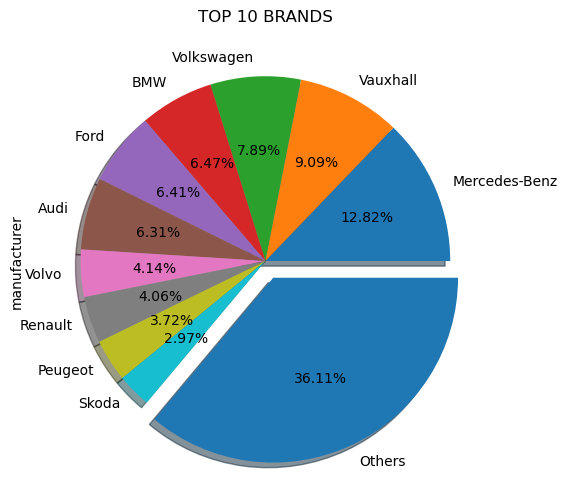

In [8]:
# n.b., i termini "manufacturer" e "brand" sono utilizzati come sinonimi
print("[" + str(uk_emissions["manufacturer"].nunique()) \
      + "] different manufacturers and ["               \
      + str(uk_emissions["manufacturer"].count())       \
      + "] total cars are registered")
manufacturers = uk_emissions["manufacturer"].value_counts()
majority_brands = manufacturers[:10]
minority_brands = manufacturers[10:]
# oppure raggruppando i brand che rappresentano meno del 5%
# minority_brands_perc = manufacturers[manufacturers < uk_emissions["manufacturer"].count() * 5 / 100]
majority_brands["Others"] = minority_brands.sum()
my_explode = np.append(np.zeros(majority_brands.count() - 1), 0.1)
majority_brands.plot.pie(title = "TOP 10 BRANDS", explode = my_explode, shadow = True, autopct = "%.2f%%", figsize=(6, 6));

In [9]:
print("OTHERS: 11th to 62nd brand in descending order of popularity:\n")
percentages = minority_brands.to_numpy() * 100 / uk_emissions["manufacturer"].count()
list_of_series = [minority_brands.index.values, minority_brands.values, percentages]
minority_df = pd.DataFrame({"manufacturer"  : minority_brands.index.values, 
                            "# occurrences" : minority_brands.values,
                            "percentage"    : percentages})
n_brands = uk_emissions["manufacturer"].nunique()
minority_df.index = range(11, n_brands + 1)
print(minority_df)

OTHERS: 11th to 62nd brand in descending order of popularity:

            manufacturer  # occurrences  percentage
11                 Honda           1222    2.685065
12               Citroen           1139    2.502692
13                  Saab            902    1.981938
14                Toyota            868    1.907231
15            Mitsubishi            767    1.685307
16                   Kia            721    1.584232
17                  Seat            710    1.560062
18                  Fiat            702    1.542484
19                Nissan            666    1.463382
20               Hyundai            641    1.408451
21                 Mazda            635    1.395267
22         Chrysler Jeep            610    1.340335
23               Porsche            606    1.331546
24                Subaru            577    1.267825
25                Suzuki            531    1.166751
26        MG Rover Group            470    1.032717
27            Alfa Romeo            465    1.021731
2

Manufacturers left after screening: [10]


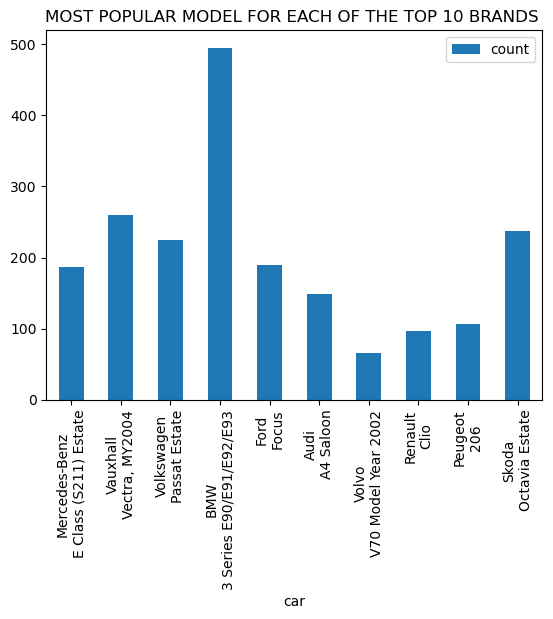

In [10]:
# ISTOGRAMMA 1 => modello più presente nei TOP 10 brand (spiegare motore o trasmissione differente)
brands_and_models = uk_emissions[["manufacturer", "model"]].copy()
brands_and_models = brands_and_models[brands_and_models.manufacturer.isin(majority_brands.index)]
print("Manufacturers left after screening: [" + str(brands_and_models.manufacturer.nunique()) + "]")
majority_brands = majority_brands.drop("Others")
brands_and_models = brands_and_models.value_counts(["manufacturer", "model"]) \
        .reset_index(name = "count")                                          \
        .sort_values(["count"], ascending = False)                            \
        .drop_duplicates(["manufacturer"])                                    \
        .set_index(["manufacturer"])                                          \
        .reindex(majority_brands.index) # ri-ordiniamo secondo la classifica dei brand stilata in precedenza
brands_and_models["car"] = brands_and_models.index + "\n" + brands_and_models["model"] # concateniamo le stringhe
brands_and_models.plot.bar(title = "MOST POPULAR MODEL FOR EACH OF THE TOP 10 BRANDS ", x = "car", y = "count");

In [11]:
# MEDIA & VALORI DISTINTI => MEDIA # DI MOTORI ALTERNATIVI × 1 MODELLO
# attenzione a modelli con stesso nome in due brand diversi !!! ignoriamo le differenze in trasmissione
n_cars = len(uk_emissions[["manufacturer", "model", "description"]].copy().drop_duplicates())
n_models = len(uk_emissions[["manufacturer", "model"]].copy().drop_duplicates())
n_brands = len(uk_emissions[["manufacturer"]].copy().drop_duplicates())
print("Average number of engine variants per model: [{:.2f}]".format(n_cars / n_models))
print("Average number of models per manufacturer:  [{:.2f}]".format(n_models / n_brands))

Average number of engine variants per model: [9.85]
Average number of models per manufacturer:  [43.05]


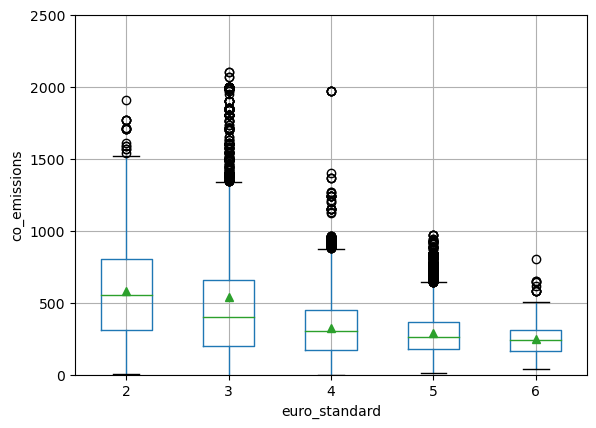

In [12]:
# QUARTILI => C0 EMISSIONS (Monossido di carbonio) X EURO
quartiles_first = uk_emissions.boxplot(column = "co_emissions", by = "euro_standard", showmeans = True);
quartiles_first.set_ylabel("co_emissions");
quartiles_first.set_title("");
plt.ylim(0, 2500);
plt.suptitle("");

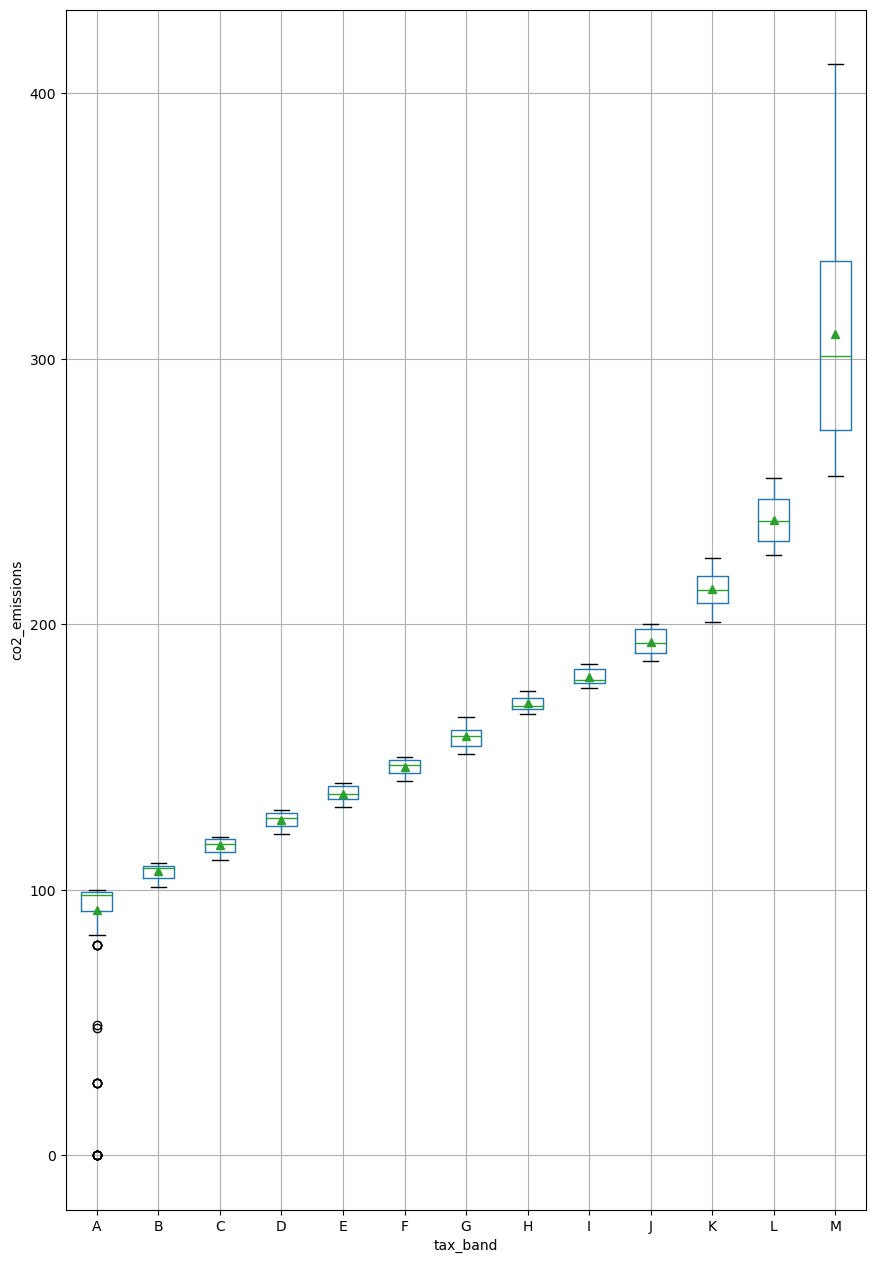

In [13]:
# QUARTILI => C02 EMISSIONS X TAX_BAND
quartiles_second = uk_emissions.boxplot(column = "co2", by = "tax_band", showmeans=True, figsize = (10, 16));
quartiles_second.set_ylabel("co2_emissions");
quartiles_second.set_title("");
plt.suptitle("");

In [14]:
# DISPERSIONE & INDICI CORRELAZIONE => ANNO & NOX_EMISSIONS
# uk_emissions.plot.scatter("year", "nox_emissions", s=7, c="red");

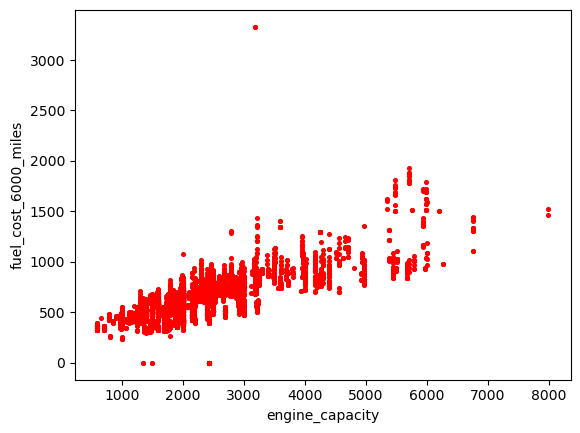

In [15]:
# DISPERSIONE & INDICI CORRELAZIONE => ENGINE_CAPACITY & FUEL_COST
uk_emissions.plot.scatter("engine_capacity", "fuel_cost_6000_miles", s=7, c="red");

# Esplorazione del dataset `spain_emissions`
### Rimozione delle righe riguardanti veicoli elettrici

All'interno del dataset proveniente dal ministero spagnolo sono presenti anche dati riguardanti macchine elettriche. Questa tipologia di dato non è interessante per l'obiettivo del modello, ovvero la quantità di CO<sub>2</sub> emessa.

La cella seguente analizza i valori delle righe che hanno `engine_type` "Eléctricos puros", estraendo solo le colonne sul minimo e massimo di consumo di litri di carburante e sul minimo e massimo di emissioni di CO<sub>2</sub> per km percorso.

In [16]:
columns = ["emissions_min_gCO2_km", "emissions_max_gCO2_km"]
spain_emissions.loc[spain_emissions["engine_type"] == "Eléctricos puros", columns].isna().all()

emissions_min_gCO2_km    True
emissions_max_gCO2_km    True
dtype: bool

Come era previdibile, tutti i valori delle emissioni di CO<sub>2</sub> per km nelle righe riguardanti i veicoli elettrici sono mancanti, quindi le rispettive righe possono essere eliminate, poichè non utili per l'addestramento del modello, il cui obiettivo è la previsione dell'emissione di CO<sub>2</sub> per veicoli a motore termico.

In [17]:
electric_cars_index = spain_emissions.loc[spain_emissions["engine_type"] == "Eléctricos puros"].index
spain_emissions = spain_emissions.drop(electric_cars_index)
spain_emissions["engine_type"].unique()

array(['Gasolina', 'Gasóleo', 'Híbridos enchufables',
       'Híbridos de gasolina', 'Gas natural', 'Híbridos de gasóleo',
       'Gases licuados del petróleo (GLP)', 'Pila de combustible',
       'Autonomía extendida'], dtype=object)


Come si può notare dall'output della cella precedente, la colonna `engine_type` non contiene il valore "Eléctricos puros".

### Rimozione delle colonne contenenti solo valori `NaN`
Nel dataset dell'emissioni di CO<sub>2</sub> proveniente dalla Spagna la colonne `type_hybrid`, `electric_consumption_kwh_100km`, `battery_capacity_kwh ` contengono solo valori `NaN`.

In [18]:
all_nan_columns = ["type_hybrid", "electric_consumption_kwh_100km", "battery_capacity_kwh"]
spain_emissions[all_nan_columns].isna().values.all()

True

In [19]:
spain_emissions = spain_emissions.drop(all_nan_columns, axis=1)

### Rimozione delle righe senza un valore valido di trasmissione
La colonna `transmission` contiene il tipo di trasmissione del veicolo, quindi la modalità di cambio della marcia, se automatica o manuale, che nella colonna sono rispettivamente "A" e "M". L'output della prossima cella mostra che sono presenti 35 righe con valori di trasmissioni non validi, poichè nel dataset spagnolo "SC" sta per "Sin clasificasion", ovvero non classificato. Perciò le righe con valori di trasmissione non validi, essendo un numero molto ridotto, verrano eliminate.

In [20]:
spain_emissions["transmission"].value_counts()

A     7735
M     7337
SC      33
0        2
Name: transmission, dtype: int64

In [21]:
valid_transmissions = spain_emissions["transmission"].isin(["A", "M"])
spain_emissions["transmission"] =  spain_emissions.loc[valid_transmissions, "transmission"]

# Esplorazione del dataset `canada_emissions`

### Gestione dimensioni motore

All'interno del dataset proveniente dal ministero canadese sono presenti le dimensioni in L (Litri) del motore dei vari veicoli. Decidiamo di trasformarle in cm$^3$ rinominando quindi la feature Engine_cm3.

In [22]:
canada_emissions = canada_emissions.rename(columns={"Engine size (L)": "Engine_cm3"})
canada_emissions["Engine_cm3"] = canada_emissions["Engine_cm3"] * 1000
canada_emissions.head(5)

,_id,Model year,Make,Model,Vehicle class,Engine_cm3,Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km)
0,1,1995,Acura,Integra,Subcompact,1800.0,4,A4,X,10.2,7.0,8.8,32,202
1,2,1995,Acura,Integra,Subcompact,1800.0,4,M5,X,9.6,7.0,8.4,34,193
2,3,1995,Acura,Integra GS-R,Subcompact,1800.0,4,M5,Z,9.4,7.0,8.3,34,191
3,4,1995,Acura,Legend,Compact,3200.0,6,A4,Z,12.6,8.9,10.9,26,251
4,5,1995,Acura,Legend Coupe,Compact,3200.0,6,A4,Z,13.0,9.3,11.3,25,260


### Trattamento valori mancanti

Con la cella seguente verifico se il dataset contiene dei dati mancanti (nan).

In [23]:
canada_emissions.isna().values.any()

False

Visto che il risultato è false non c'è alcun valore mancante da gestire.

### Grafici 
Questa sezione contiene alcuni grafici che evidenziano alcuni aspetti del dataframe `canada_emissions`.

L'istogramma seguente mostra la distribuzione delle emissioni di CO$_2$ nel dataframe canadese. I valori si concentrano principalmente nell'intervallo [150,350].

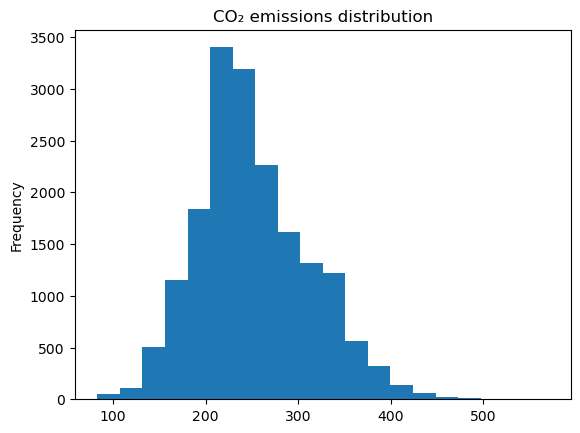

In [24]:
canada_emissions["CO2 emissions (g/km)"].plot.hist(bins=20,title="CO\u2082 emissions distribution");

L'istogramma seguente mostra le dimensioni dei motori dei vari veicoli nel dataframe canadese. I valori si concentrano principalmente nell'intervallo [1500,6000].

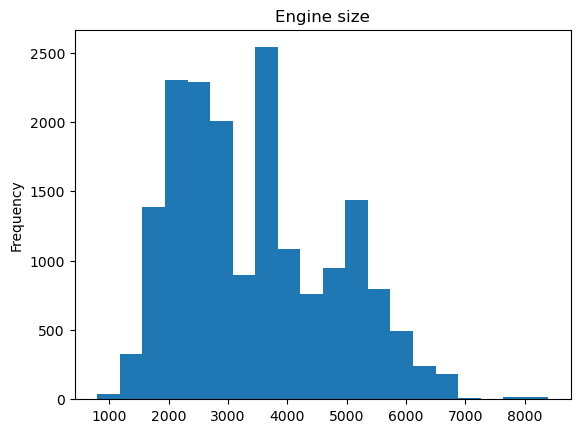

In [25]:
canada_emissions["Engine_cm3"].plot.hist(bins=20,title="Engine size");

Il seguente grafico a torta mostra il numero di cilindri (in percentuale) dei vari veicoli nel dataframe canadese. La maggior parte di essi ha 6 cilindri.

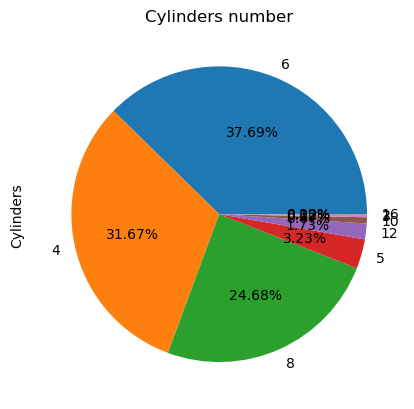

In [26]:
canada_emissions["Cylinders"].value_counts().plot.pie(title="Cylinders number" ,autopct="%.2f%%")
plt.show()

Il seguente grafico a barre mostra i vari tipi di veicoli presenti nel dataset canadese con la relativa frequenza.

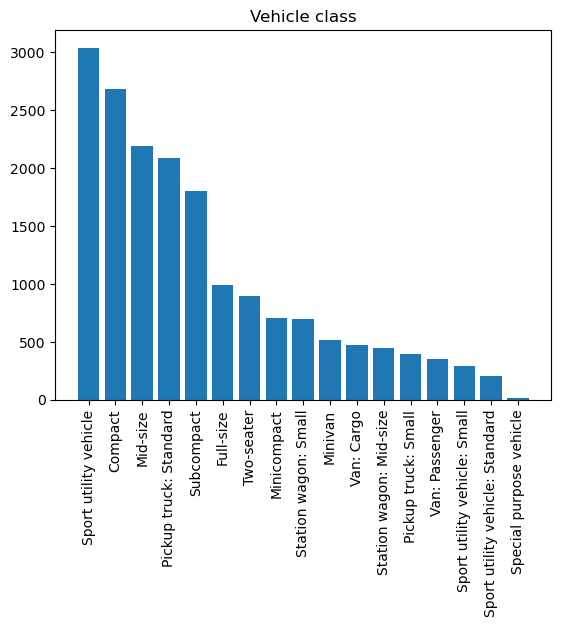

In [27]:
canada_vehicle_class = canada_emissions["Vehicle class"].value_counts()
plt.bar(canada_vehicle_class.index, canada_vehicle_class.values)
plt.xticks(rotation='vertical')
plt.title("Vehicle class")
plt.show()

# **Omogeneizzazione ed unione dei dati**
Avendo reperito tre set di dati ciascuno da una fonte differente, sebbene questi concernano il medesimo dominio e condividano pertanto una considerevole quantità di attributi, potremmo essere erroneamente portati a compiere un troncamento delle colonne, conservando esclusivamente quelle appartenenti all'intersezione delle tre tabelle, tuttavia così facendo andremmo a trascurare il caso-limite in cui le features eliminate dovessero essere le uniche legate, attraverso un relazione non randomica, a quella indagata. Una soluzione più scrupolosa consisterebbe, al contrario, nell'**unione** degli **attributi**, colmando opportunamente le celle vuote formatesi. In effetti, come visto a lezione, i valori NAN possono essere sostituiti, tra gli altri, da (a seconda che le colonne siano di tipo categorico o numerico):
- media
- moda
- mediana

In aggiunta, le stesse variabili in comune, malgrado facciano riferimento allo stesso concetto, si manifestano saltuariamente sotto denominazioni diverse, ed a loro volta i valori da queste assunti potrebbero avere formato dissimile (e.g. capitalizzazione delle lettere nel caso testuale o numero di cifre significative in quello numerico). 







## Omogeneizzazione di `spain_emissions`

### Traduzione spagnolo-inglese 
Il dataset proveniente dalla Spagna contiene due colonne in spagnolo, `engine_type` e `market_segment`. Quindi è necessaria una traduzione dallo spagnolo all'inglese per entrambe le colonne, così da adattarle agli altri due dataset.

Definisco una funzione per sostituire i valori di una colonna di un dataframe con dei nuovi valori passati come argomento, in questo caso la rispettiva traduzione in inglese, tramite una funzione di mapping fornita da pandas.

In [28]:
def get_column_mapped_values(column, new_values):
    mapping = dict(zip(column.unique(), new_values))
    return column.map(mapping)

In [29]:
#Traduzione della colonna engine_type
spanish_engine_type = spain_emissions["engine_type"].unique()
english_engine_type = ["Petrol", "Diesel", "Plug-in hybrid", "Petrol hybrid", "Natural gas", 
                       "Diesel Hybrid", "Liquefied petroleum gas(LPG)", "Fuel cell", "Extended range"]

spain_emissions["engine_type"] = get_column_mapped_values(spain_emissions["engine_type"], english_engine_type)

Per la traduzione della colonna `market_segment` si fa riferimento al dataset canadese, il quale contiene una colonna per la classificazione dei veicoli, `Vehicle class`.


In [30]:
canada_emissions["Vehicle class"].unique()

array(['Subcompact', 'Compact', 'Two-seater', 'Station wagon: Small',
       'Minicompact', 'Mid-size', 'Full-size', 'Station wagon: Mid-size',
       'Van: Cargo', 'Van: Passenger', 'Pickup truck: Standard',
       'Sport utility vehicle', 'Minivan', 'Pickup truck: Small',
       'Special purpose vehicle', 'Sport utility vehicle: Small',
       'Sport utility vehicle: Standard'], dtype=object)

In [31]:
#Traduzione della colonna market_segment
english_market_segment = ["Minicompact", "Compact", "Small off-road", "Mid-size", "Sport utility vehicle", "Full-size", 
                          "Mid-size off-road", "Full-size off-road", "Minivan", "Luxury", "Minivan", "Van: Passenger"] \
                        + (["Van: Cargo"] * 2) + (["Lorry"] * 7)

spain_emissions["market_segment"] = get_column_mapped_values(spain_emissions["market_segment"], english_market_segment)

### Calcolo medie del consumo di carburante e delle emissioni di CO<sub>2</sub>
Sia per il consumo di carburante che per le emissioni di CO<sub>2</sub> sono presenti i valori di minimo, di massimo e la media
WLTP (<i>Worldwide harmonized Light vehicles Test Procedure</i>), ovvero le misure ottenute dal test standard a livello mondiale per il controllo delle emissioni e dei consumi dei veicoli.
Da questi tre valori ne verrà calcolata la media così da avere una sola colonna per i consumi di carburante e una sola colonna per i consumi di CO<sub>2</sub>, la variabile target da predire.

Prima di poter precedere è necessario controllare che in tutte le righe del dataframe sia presente almeno uno dei tre valori richiesti e che sia diverso da 0, sia per calcolare la media del consumo che delle emissioni.
<br>Nella cella successiva si può vedere esattamente in quante righe sono mancanti questi valori necessari.

In [32]:
def isnaOrIsZero(dataframe):
    return dataframe.isna() | dataframe.eq(0)

In [33]:
consumption_columns = ["consumption_min_l_100km", "consumption_max_l_100km", "avg_wltp_consumption_l_100km"]
emissions_columns = ["emissions_min_gCO2_km", "emissions_max_gCO2_km", "avg_wltp_emissions_gCO2_km"]

rows_no_consumption = isnaOrIsZero(spain_emissions[consumption_columns]).all(axis=1)
number_rows_missing_consumption = rows_no_consumption.sum()
print("Rows with no consumption_l_100km:", number_rows_missing_consumption)

rows_no_emissions = isnaOrIsZero(spain_emissions[emissions_columns]).all(axis=1)
number_rows_missing_emissions = rows_no_emissions.sum()
print("Rows with no emissions_gCO2_km:", number_rows_missing_emissions)

rows_no_emissions_consumptions = (rows_no_consumption & rows_no_emissions)
number_rows_missing_emissions_consumptions = rows_no_emissions_consumptions.sum()
print("Rows with no emissions_gCO2_km and no consumption_l_km:", number_rows_missing_emissions_consumptions)

Rows with no consumption_l_100km: 1560
Rows with no emissions_gCO2_km: 1562
Rows with no emissions_gCO2_km and no consumption_l_km: 1560


Come riportato nell'output della cella precedente, ci sono <strong>1560</strong> righe senza alcun valore di consumo di carburante, <strong>1562</strong> righe senza alcun valore di emissioni di CO<sub>2</sub> e <strong>1560</strong> in cui è assente sia il consumo di carburante che le emissioni di CO<sub>2</sub>. <br> 
Nella cella successiva vengono calcolate le medie di carburante ed emissioni di ciascuna riga e vengono inserite in due nuove colonne `consumption_l_100km`, `emissions_gCO2_km`. <br>

In [34]:
mean_consumption = "consumption_l_100km"
mean_emissions = "emissions_gCO2_km"
spain_emissions[mean_consumption] = spain_emissions[consumption_columns].mean(axis=1)
spain_emissions[mean_emissions] = spain_emissions[emissions_columns].mean(axis=1)

In [35]:
spain_emissions = spain_emissions.drop(consumption_columns + emissions_columns, axis=1)

Quindi vengono sostituiti i valori mancanti e i valori posti a 0, poichè considerati anch'essi mancanti, siccome le categorie di veicoli considerate dovrebbero presentare dei consumi di carburante e delle emissioni di CO<sub>2</sub> positivi. <br>
La cella successiva mostra le categorie di veicoli in cui sono assenti sia i consumi di carburante che le emissioni. Le due categorie con più occorrenze sono i "Van: Cargo" e "Lorry", due mezzi molto pesanti e con valori differenti rispetto ad altre categorie, quindi sarebbe più corretto riempire i valori assenti o posti a 0, con i mediani delle due rispettive categorie. Mentre per le restanti categorie si può utilizzare direttamente il mediano di tutta la colonna.

In [36]:
most_missing_market_segments = spain_emissions.loc[rows_no_emissions_consumptions, "market_segment"].value_counts()[:5]
most_missing_market_segments

Van: Cargo            1202
Lorry                  327
Luxury                  15
Full-size off-road       9
Van: Passenger           3
Name: market_segment, dtype: int64

Le celle successive evidenziano la necessità di usare, come valore per riempire i valori NaN o posti a 0 delle categorie di veicoli "Van: Cargo" e "Lorry", i rispettivi mediani, anzichè usare direttamente il mediano di tutta la colonna, vista l'ampia differenza causata dalla presenza di veicoli di diverse dimensioni e consumi.

In [37]:
columns = [mean_consumption, mean_emissions]
market_segments = ["Van: Cargo", "Lorry"]

In [38]:
all_median = pd.DataFrame(spain_emissions[columns].median(), columns = ["All"]).T
van_cargo_lorries = spain_emissions.loc[spain_emissions["market_segment"].isin(market_segments), ["market_segment"] + columns]
van_cargo_lorries_median = van_cargo_lorries[van_cargo_lorries.ne(0)].groupby("market_segment").median()

In [39]:
pd.concat([all_median, van_cargo_lorries_median]).style.set_caption("Market segments medians")

,consumption_l_100km,emissions_gCO2_km
All,6.000000,141.000000
Lorry,7.900000,203.333333
Van: Cargo,7.950000,196.083333


In [40]:
def fillnaZeroes(market_segment, columns):
    vehicles = spain_emissions.loc[spain_emissions["market_segment"] == market_segment, columns].replace(0, np.nan)
    vehicles = vehicles.fillna(vehicles.median())
    return vehicles

In [41]:
for market_segment in market_segments:
    spain_emissions.loc[spain_emissions["market_segment"] == market_segment, columns] = fillnaZeroes(market_segment, columns)

In [42]:
other_market_segments = set(spain_emissions["market_segment"].unique()) - set(market_segments)
spain_emissions[columns] = spain_emissions[columns].replace(0, np.nan).fillna(spain_emissions[columns].median())

### Utilizzo di valori espliciti per il tipo di trasmissione
Il dataset spagnolo per indicare la tipologia di trasmissione utilizza solamente "A" e "M". Per adattarlo agli altri dataset e per renderlo più chiaro si è deciso di mappare i rispettivi valori con la versione estesa, ovvero "Automatic", "Manual".

In [43]:
renaming_dict = {"A": "Automatic", "M": "Manual"}
spain_emissions["transmission"] = spain_emissions["transmission"].map(renaming_dict)

### Inserimento dell'anno del modello del veicolo
I dataset canadesi e britannici presentano entrambi una colonna per l'anno del modello(`Model year` in `canada_emissions` e `year` in `uk_emissions`), una feature che può essere importante per la predezioni delle emissioni prodotte. Quindi a partire dagli altri due dataset, viene estratta la colonna dell'anno.

Prima di procedere all'inserimento è necessario un adattamento della colonna `model`, poichè nel dataset `spain_emissions` ciascun valore è formato dal nome della casa automobilistica, ovvero il valore della colonna `make`, dal nome effettivo del modello e da altre informazioni aggiuntive sul modello. Quindi, si procede all'eliminazione della casa automobilistica e delle informazioni aggiuntive per adattarlo alla colonna del modello degli altri due dataset.

La prossime due celle rimuovono suffissi non presenti negli altri due dataset, eliminando le parole contenute nella variabile locale `useless_words`.

In [44]:
useless_words = {"Canarias", "Vehículos", "Turismos", "Comerciales", "Nuevo", "NUEVO", "Turismos"}
# Per rimuovere suffissi fuorvianti, non presenti negli altri dataset, nei nomi delle case automobilistiche
def remove_useless_suffix(make):
    make_words = make.split()
    make_words = set(make_words) - useless_words
    return " ".join(make_words)

In [45]:
spain_emissions["make"] = spain_emissions["make"].apply(remove_useless_suffix)

Di seguito, l'adattamento del nome del modello eliminando la casa automobilistica e le informazioni aggiuntive.

In [46]:
# Per rimuovere il nome della casa automobilistica e le informazioni aggiuntive dal nome del modello
def remove_manufacturer_and_addional_info(make_model):
    make = make_model["make"]
    model = make_model["model"]
    removedManufacturer = model.replace(make, "").split()
    model = [word for word in removedManufacturer if word not in useless_words][0]
    return model

In [47]:
spain_emissions["model"] = spain_emissions[["make", "model"]].apply(remove_manufacturer_and_addional_info, axis=1)

Dopo l'adattamento del nome della casa automobilistica e del nome del modello del veicolo, si può procedere all'effettivo inserimento dell'anno in base ai valori dell'anno nei dataset `uk_emissions` e `canada_emissions`. I valori dell'anno che risultano non presenti a seguito del join con `uk_emissions` verranno prelevati dal secondo dataset `canada_emissions`. In caso dei valori risultassero ancora mancanti, tali righe verranno scartate dal dataset, poichè prive di un'informazione rilevante ai fini dell'addestramento del modello.

In [48]:
spain_emissions = (
    pd.merge(
        spain_emissions,
        uk_emissions[["manufacturer", "model", "year"]],
        how = "left",
        left_on = ["make", "model"],
        right_on =  ["manufacturer", "model"]
    )
    .drop_duplicates()
)[list(spain_emissions.columns) + ["year"]]

In [49]:
spain_emissions_year_na = spain_emissions[spain_emissions["year"].isna()].drop("year", axis=1)
spain_emissions_year_canada = (
    pd.merge(
        spain_emissions_year_na,
        canada_emissions[["Make", "Model", "Model year"]],
        how = "left",
        left_on = ["make", "model"],
        right_on =  ["Make", "Model"]
    )
    .drop_duplicates()
    .rename(columns = {"Model year": "year"})
)[list(spain_emissions.columns)]

La cella a seguire inserisce i valori dell'anno ottenuti dal join con `canada_emissions` al posto dei valori mancanti a seguito del join con `uk_emissions`. Infine, le righe in cui la colonna `year` risulta ancora mancante dopo i due join verranno scartate.   

In [50]:
spain_emissions["year"] = spain_emissions["year"].fillna(spain_emissions_year_canada["year"])
spain_emissions = spain_emissions.dropna()

### Grafici di `spain_emissions`
Questa sezione contiene alcuni grafici che evidenziano alcuni aspetti del dataframe risultante `spain_emissions`.value_countsunique

L'istogramma seguente mostra la distribuzione delle emissioni di CO<sub>2</sub> nel dataset spagnolo. I valori si concentrano principalmente nell'intervallo [100, 200].

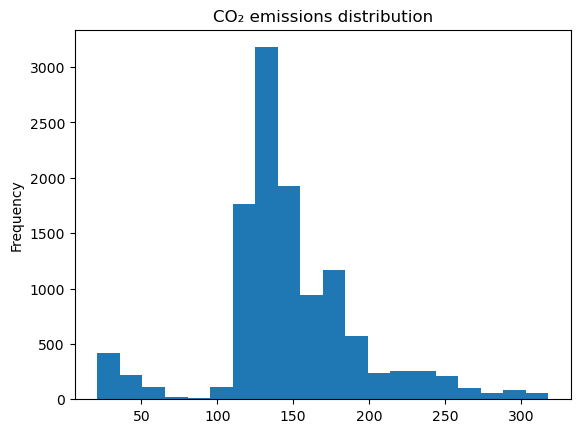

In [51]:
spain_emissions["emissions_gCO2_km"].plot.hist(bins=20,title="CO\u2082 emissions distribution");

Il seguente grafico mostra la correlazione tra il consumo di carburante e le emissioni di CO<sub>2</sub>. Si evince che esiste una dipendenza tra i due valori, fatta eccezione per alcuni punti. 

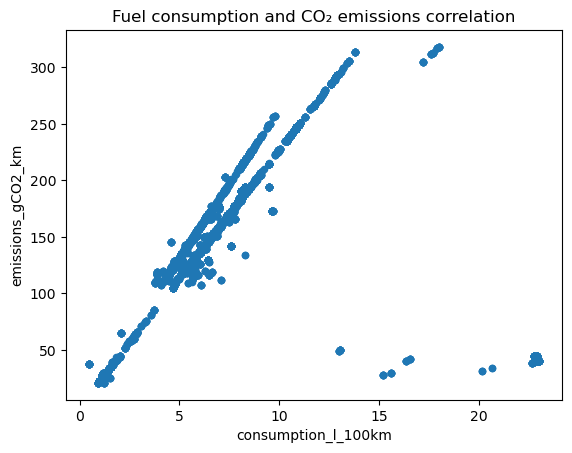

In [52]:
spain_emissions.plot.scatter("consumption_l_100km", "emissions_gCO2_km", title="Fuel consumption and CO\u2082 emissions correlation");

Nel grafico a torta è rappresentata la distribuzione delle categorie di veicoli. Una metà è occupata da sole 4 categorie, mentre le altre 9 si spartiscono il restante 50%.

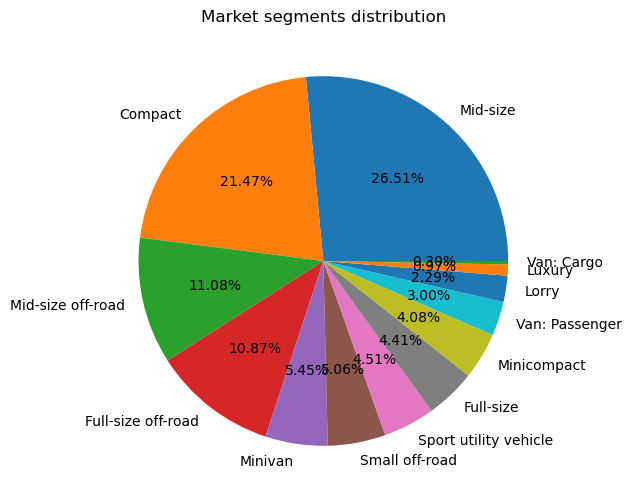

In [53]:
spain_emissions["market_segment"].value_counts().plot.pie(autopct="%.2f%%", title="Market segments distribution", label="", figsize=(6,6));

Nel seguente grafico è mostrata la relazione tra ciascuna categoria di veicoli e le emissioni di CO<sub>2</sub> corrispondenti. Sono presenti molti outlier sia nella parte inferiore che nella parte superiore di ciascun boxplot. Si può notare come i le medie dei valori di veicoli più pesanti e più inquinanti come "Lorry", "Van: Cargo" e "Luxury" siano molto più alti delle medie dei valori corrispondenti ai veicoli più leggeri e meno inquinanti come "Compact", "Minicompact" e "Mid-size". Questa osservazione è vera solo per le medie e i mediani, siccome i valori di ciascun boxplot coprono una buona parte dell'asse y, quindi alcuni veicoli "Compact" hanno valori più alti di alcuni "Lorry".

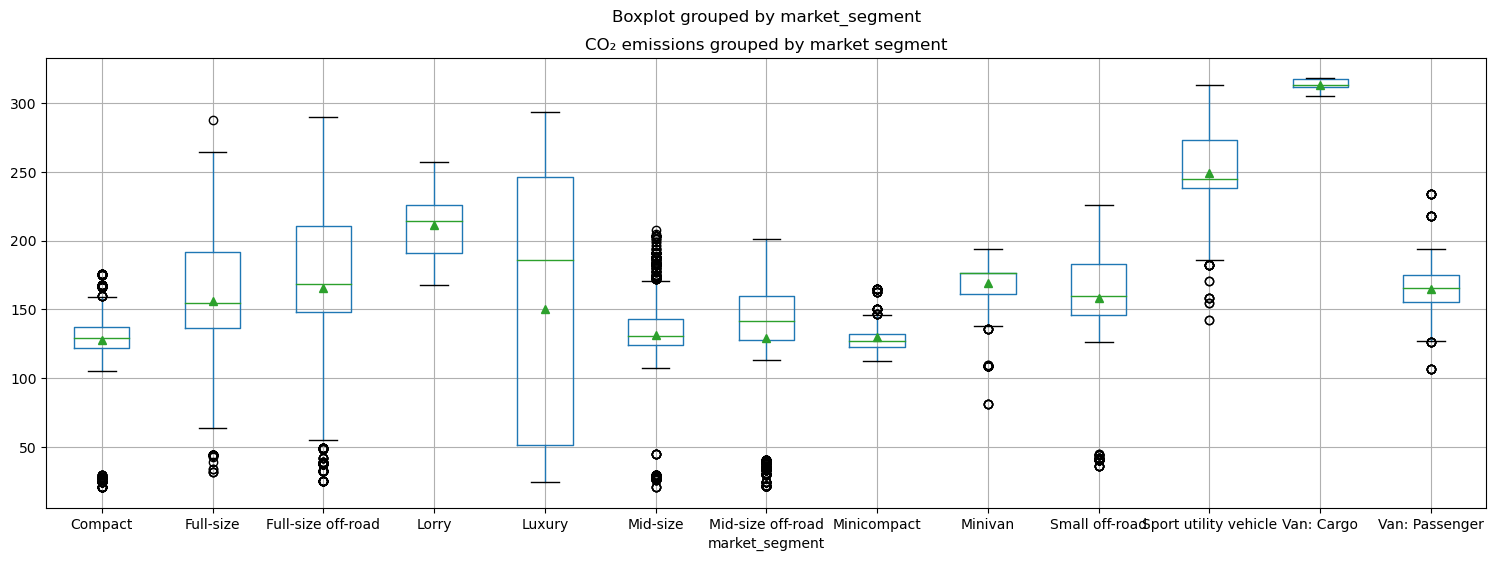

In [54]:
spain_emissions.boxplot(column="emissions_gCO2_km", by="market_segment", showmeans=True, figsize=(18, 6)).set_title("CO\u2082 emissions grouped by market segment");

Mentre nel grafico successivo vengono mostrati gli stessi valori, ma in relazione alla tipologia di motore. Quasi tutti boxplot hanno i valori di media e mediana che si assestano tra 150 e 200, presentando però anche in questo caso molti outlier.

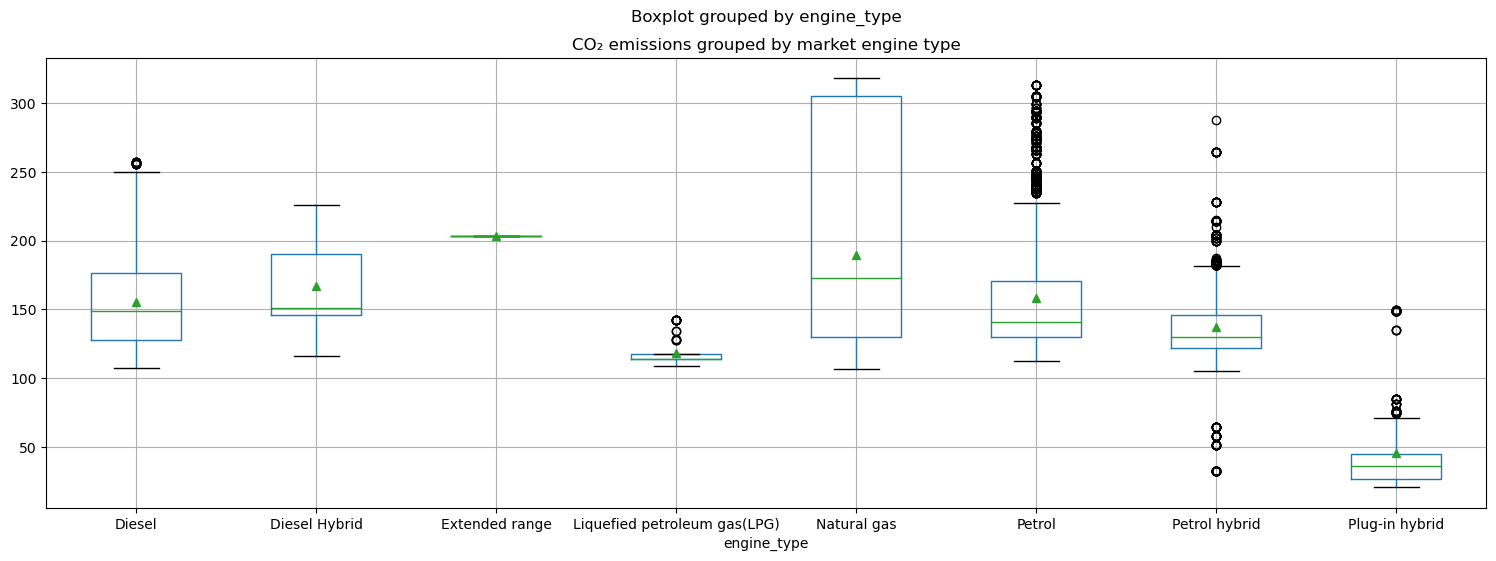

In [55]:
spain_emissions.boxplot(column="emissions_gCO2_km", by="engine_type", showmeans=True, figsize=(18, 6)).set_title("CO\u2082 emissions grouped by market engine type");

### Scelta delle colonne di `spain_emissions` per l'addestramento
Questa ultima parte dell'omogeneizzazione di `spain_emissions` seleziona solo le colonne utilizzate nell'addestramento rinominandole e facendo le ultime modifiche ai valori delle colonne, in modo da utilizzare uno standard comune agli altri dataset.

In [56]:
old_columns = ["year", "make", "model", "engine_displacement_cm3", "consumption_l_100km", "engine_type", "emissions_gCO2_km", "transmission"] 
new_columns = ["Year", "Manufacturer", "Model", "Engine_cm3", "Fuel_consumption", "Fuel_type", "CO2_Emissions", "Transmission_type"]
columns_dict = dict(zip(old_columns, new_columns))

In [57]:
spain_emissions = spain_emissions[old_columns].rename(columns = columns_dict)

Da questo punto in poi, Liquefied Petroleum Gas (LPG) verrà semplicemente sostituito con LPG.

In [58]:
spain_emissions["Fuel_type"] = spain_emissions["Fuel_type"].replace("Liquefied petroleum gas(LPG)", "LPG")

# **Omogeneizzazione di `canada_emissions`**

### Gestione tipi di carburante

All'interno del dataset proveniente dal ministero canadese sono presenti dati riguardanti il tipo di carburante (colonna "Fuel type"). 

La cella seguente mostra il numero di occorrenze di ogni lettera nella colonna Fuel type.

In [59]:
canada_emissions["Fuel type"].value_counts()

X    10445
Z     6314
E      770
D      199
N       38
Name: Fuel type, dtype: int64

Riportiamo sotto il significato delle lettere.

- `X`: Benzina normale (ha un indice di ottano più basso ed è quindi meno resistente alla detonazione)
- `Z`: Benzina premium (ha un indice di ottano più alto e offre una maggiore resistenza alla detonazione. È ideale per motori ad alte prestazioni, che hanno un rapporto di compressione                           più elevato e richiedono un carburante più stabile.)
- `D`: Diesel
- `E`: Etanolo(E85)
- `N`: gas naturale

Per motivi di compatibilità dei dataset è superfluo mantenere la distinzione tra benzina normale e benzina premium. Compattiamo quindi le due lettere X e Z in una parola unica: Petrol.
Inoltre trasformiamo anche E in Etanolo, N in Natural gas e D in Diesel per gli stessi motivi di confrontabilità.
Prima di iniziare a modificare il dataframe per poter effettuare tutte le doverose modifiche per renderlo confrontabile con gli altri dataset ne salviamo una copia per evitare di perdere quello originale che potrebbe tornare utile.

In [60]:
canada_emissions_copy = canada_emissions.copy()
canada_emissions["Fuel type"] = canada_emissions["Fuel type"].replace({'X': 'Petrol', 'Z': 'Petrol', 'D': 'Diesel', 'N': 'Natural Gas', 'E': 'Ethanol'})
canada_emissions["Fuel type"].value_counts()

Petrol         16759
Ethanol          770
Diesel           199
Natural Gas       38
Name: Fuel type, dtype: int64

Il seguente grafico a torta mostra la percentuale dei diversi tipi di carburante presi in considerazione. Si può notare che la maggior parte dei dati riguardano veicoli a benzina.

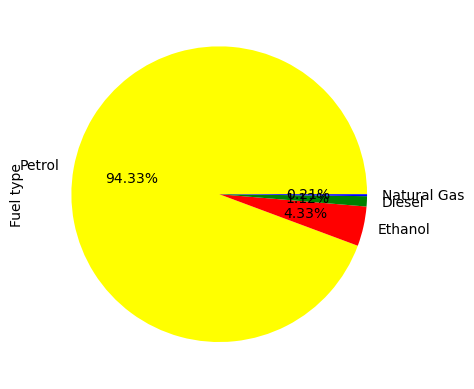

In [61]:
fuel_type_colors = {"Petrol": "yellow", "Ethanol": "red", "Diesel": "green", "Natural Gas": "blue"}
canada_fuel_type = canada_emissions["Fuel type"].value_counts()
canada_fuel_type.plot.pie(colors = canada_fuel_type.index.map(fuel_type_colors), autopct="%.2f%%")
plt.show()

### Eliminazione colonne superflue e rename delle feature importanti

E' inoltre doveroso eliminare le feature City, Highway, Combined che indicano rispettivamente il consumo di carburante: nelle strade di città, nelle autostrade e in entrambe. Eliminiamo inoltre la colonna superflua dell'id, quella del tipo veicolo (Vehicle class) e quella del numero di cilindri (Cylinders) del veicolo, non presente negli altri dataframe.

In [62]:
canada_emissions = canada_emissions.drop(["_id","Highway (L/100 km)","City (L/100 km)", "Combined (L/100 km)", "Vehicle class", "Cylinders"], axis=1)
canada_emissions.head(5)

,Model year,Make,Model,Engine_cm3,Transmission,Fuel type,Combined (mpg),CO2 emissions (g/km)
0,1995,Acura,Integra,1800.0,A4,Petrol,32,202
1,1995,Acura,Integra,1800.0,M5,Petrol,34,193
2,1995,Acura,Integra GS-R,1800.0,M5,Petrol,34,191
3,1995,Acura,Legend,3200.0,A4,Petrol,26,251
4,1995,Acura,Legend Coupe,3200.0,A4,Petrol,25,260


La celle seguente serve solo per modificare i nomi delle feature in modo che siano compatibili con gli altri dataset.

In [63]:
canada_emissions = canada_emissions.rename(columns={"Model year": "Year","Make": "Manufacturer","Fuel type": "Fuel_type", "Transmission": "Transmission_type","Combined (mpg)": "Fuel_consumption", "CO2 emissions (g/km)": "CO2_Emissions"})
canada_emissions.head(5)

,Year,Manufacturer,Model,Engine_cm3,Transmission_type,Fuel_type,Fuel_consumption,CO2_Emissions
0,1995,Acura,Integra,1800.0,A4,Petrol,32,202
1,1995,Acura,Integra,1800.0,M5,Petrol,34,193
2,1995,Acura,Integra GS-R,1800.0,M5,Petrol,34,191
3,1995,Acura,Legend,3200.0,A4,Petrol,26,251
4,1995,Acura,Legend Coupe,3200.0,A4,Petrol,25,260


### Gestione del tipo di trasmissione

Le prossime celle servono per rendere confrontabili con gli altri dataframe i valori riguardanti il tipo di trasmissione. In particolare trasformiamo tutti i valori di trasmissioni inizianti per A in Automatic e tutti quelli inizianti per M in Manual eccetto per i valori AM (che sarebbero automated manual) che verranno eliminati per evitare incomprensioni dato che gli altri dataset distinguono solamente tra cambio manuale e automatico.

In [64]:
index_to_drop = canada_emissions[canada_emissions["Transmission_type"].str.startswith("AM")].index
canada_emissions = canada_emissions.drop(index_to_drop)
canada_emissions["Transmission_type"] = canada_emissions["Transmission_type"].replace({r'^M.*': 'Manual',r'^A.*': 'Automatic' }, regex=True)
canada_emissions["Transmission_type"].value_counts()

Automatic    12730
Manual        4848
Name: Transmission_type, dtype: int64

Mostriamo ora i risultati appena ottenuti in un grafico a torta.

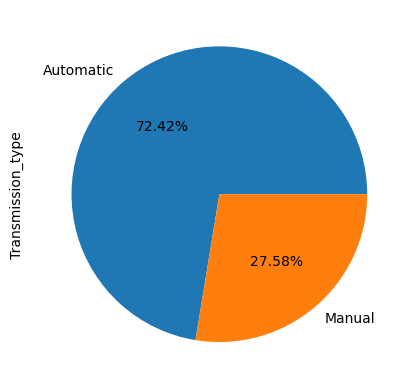

In [65]:
canada_emissions["Transmission_type"].value_counts().plot.pie(autopct="%.2f%%")
plt.show()

Come ci aspettavamo grazie allì'uso della funzione `value_counts()` i veicoli a cambio automatico sono la maggioranza.

### Dataset risultante

Di seguito, l'adattamento finale del nome del modello eliminando la casa automobilistica e le informazioni aggiuntive.

In [66]:
# Per rimuovere il nome della casa automobilistica e le informazioni aggiuntive dal nome del modello
def remove_manufacturer(make_model):
    make = make_model["Manufacturer"]
    model = make_model["Model"]
    removedManufacturer = model.replace(make, "").split()
    model = [word for word in removedManufacturer if word not in useless_words][0]
    return model

In [67]:
canada_emissions["Model"] = canada_emissions[["Manufacturer", "Model"]].apply(remove_manufacturer, axis=1)

Mostriamo di seguito il dataframe risultante `canada_emissions`

In [68]:
canada_emissions.head(10)

,Year,Manufacturer,Model,Engine_cm3,Transmission_type,Fuel_type,Fuel_consumption,CO2_Emissions
0,1995,Acura,Integra,1800.0,Automatic,Petrol,32,202
1,1995,Acura,Integra,1800.0,Manual,Petrol,34,193
2,1995,Acura,Integra,1800.0,Manual,Petrol,34,191
3,1995,Acura,Legend,3200.0,Automatic,Petrol,26,251
4,1995,Acura,Legend,3200.0,Automatic,Petrol,25,260
5,1995,Acura,Legend,3200.0,Manual,Petrol,25,258
6,1995,Acura,NSX,3000.0,Automatic,Petrol,24,267
7,1995,Acura,NSX,3000.0,Manual,Petrol,25,255
8,1995,Alfa Romeo,164,3000.0,Automatic,Petrol,22,301
9,1995,Alfa Romeo,164,3000.0,Manual,Petrol,24,267


In [69]:
emissions = pd.concat([spain_emissions, canada_emissions], ignore_index=True)

Infine, per i contenuti di tipo stringa come `Manufacturer` e `Model`, sarà necessaria una standardizzazione tra i diversi dataset. Lo standard scelto è la maiuscola per il primo carattere e la minuscola per gli altri caratteri.

In [70]:
capitalize_columns = ["Manufacturer", "Model"]
emissions[capitalize_columns] = emissions[capitalize_columns].apply(lambda col: col.str.capitalize())

In [71]:
emissions.describe()

,Year,Engine_cm3,Fuel_consumption,CO2_Emissions
count,29285.000000,29285.000000,29285.000000,29285.000000
mean,2006.755233,2761.425508,18.864523,209.882923
std,5.145139,1428.587678,11.689391,75.329636
min,1995.000000,110.000000,0.450000,21.000000
25%,2003.000000,1598.000000,6.450000,146.133333
50%,2008.000000,2400.000000,20.000000,207.000000
75%,2011.000000,3600.000000,28.000000,258.000000
max,2014.000000,19894.000000,78.000000,570.000000


# Addestramento modelli

In [72]:
emissions_train = emissions.sample(frac=0.6, random_state=42)
X = emissions_train.drop(["CO2_Emissions"], axis=1)
y = emissions_train["CO2_Emissions"]
emissions_test = emissions.drop(emissions_train.index)

In [73]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

categorical_features = X.select_dtypes(include="object").columns
numerical_features = X.select_dtypes(exclude="object").columns

preprocessor = ColumnTransformer([
    ( "numeric"    , StandardScaler(), numerical_features ),
    ( "categorical", OneHotEncoder(handle_unknown='ignore') , categorical_features )
])

In [74]:
X[categorical_features] = X[categorical_features].astype("category")

In [75]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=1/3,
    random_state=42
)

## Linear Regression

In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("preproc", preprocessor),
    ("regr"   , LinearRegression())
])

In [77]:
%time model.fit(X_train, y_train)

Wall time: 150 ms


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  Index(['Year', 'Engine_cm3', 'Fuel_consumption'], dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Manufacturer', 'Model', 'Fuel_type', 'Transmission_type'], dtype='object'))])),
                ('regr', LinearRegression())])

In [78]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

def print_eval(X, y, model):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    re = relative_error(y, preds)
    r2 = r2_score(y, preds)
    print(f"   Mean squared error: {mse:.5}")
    print(f"       Relative error: {re:.5%}")
    print(f"R-squared coefficient: {r2:.5}")

In [79]:
print_eval(X_val, y_val, model)

   Mean squared error: 426.88
       Relative error: 8.81136%
R-squared coefficient: 0.92534


In [92]:
pd.set_option('display.max_rows', None)
#pd.Series(model.named_steps["regr"].coef_, preprocessor.get_feature_names_out(X.columns))

## Polynomial Regression

In [81]:
from sklearn.preprocessing import PolynomialFeatures

In [82]:
model = Pipeline([
    ("preproc", preprocessor),
    ("poly", PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ("regr"   , LinearRegression())
])

In [83]:
%time model.fit(X_train, y_train)

Wall time: 42.5 s


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  Index(['Year', 'Engine_cm3', 'Fuel_consumption'], dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Manufacturer', 'Model', 'Fuel_type', 'Transmission_type'], dtype='object'))])),
                ('poly',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('regr', LinearRegression())])

In [84]:
print_eval(X_val, y_val, model)

   Mean squared error: 100.42
       Relative error: 3.09461%
R-squared coefficient: 0.98244


## Lasso Regression

In [93]:
from sklearn.linear_model import Lasso
model = Pipeline([
    ("preproc", preprocessor),
    #("poly", PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ("regr", Lasso(alpha=1, max_iter=10000))
])

In [94]:
%time model.fit(X_train, y_train)

Wall time: 101 ms


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  Index(['Year', 'Engine_cm3', 'Fuel_consumption'], dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Manufacturer', 'Model', 'Fuel_type', 'Transmission_type'], dtype='object'))])),
                ('regr', Lasso(alpha=1, max_iter=10000))])

In [95]:
pd.set_option('display.max_rows', None)
coefficients = pd.Series(model.named_steps["regr"].coef_, preprocessor.get_feature_names_out(X.columns))
non_zero_coefficients = coefficients[coefficients != 0]
non_zero_coefficients

numeric__Year                           -11.195530
numeric__Engine_cm3                      55.679179
numeric__Fuel_consumption                 0.277987
categorical__Fuel_type_Petrol            23.411264
categorical__Fuel_type_Petrol hybrid     -8.923469
categorical__Fuel_type_Plug-in hybrid   -83.304663
dtype: float64

## Grid Search per l'iperparametro della Lasso

In [96]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

kfold_5 = KFold(5, shuffle=True, random_state=37)
alphas = np.logspace(-3, 2, num=6)
grid = {"regr__alpha": alphas}
gs = GridSearchCV(model, grid, cv=kfold_5)

In [97]:
%time gs.fit(X, y);

Wall time: 2min 42s


GridSearchCV(cv=KFold(n_splits=5, random_state=37, shuffle=True),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         Index(['Year', 'Engine_cm3', 'Fuel_consumption'], dtype='object')),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['Manufacturer', 'Model', 'Fuel_type', 'Transmission_type'], dtype='object'))])),
                                       ('regr',
                                        Lasso(alpha=1, max_iter=10000))]),
             param_grid={'regr__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e

In [98]:
gs.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  Index(['Year', 'Engine_cm3', 'Fuel_consumption'], dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Manufacturer', 'Model', 'Fuel_type', 'Transmission_type'], dtype='object'))])),
                ('regr', Lasso(alpha=0.001, max_iter=10000))])

In [99]:
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regr__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,19.724152,3.593925,0.010564,0.008960,0.001,{'regr__alpha': 0.001},0.925582,0.925292,0.933860,0.935084,0.918391,0.927642,0.006154,1
1,7.503777,0.626138,0.003124,0.006249,0.01,{'regr__alpha': 0.01},0.912712,0.914011,0.928272,0.927128,0.901653,0.916755,0.009922,2
2,0.424875,0.024498,0.012640,0.006326,0.1,{'regr__alpha': 0.1},0.860896,0.863330,0.893796,0.886197,0.844229,0.869689,0.017998,3
3,0.116336,0.007491,0.006226,0.007626,1.0,{'regr__alpha': 1.0},0.807676,0.812358,0.846146,0.836360,0.783663,0.817241,0.022108,4
4,0.090849,0.006045,0.009373,0.007653,10.0,{'regr__alpha': 10.0},0.676752,0.687791,0.707056,0.712702,0.651361,0.687132,0.022084,5
5,0.037500,0.007653,0.009375,0.007654,100.0,{'regr__alpha': 100.0},-0.000095,-0.000082,-0.001386,-0.001385,-0.000336,-0.000657,0.000602,6
